In [50]:
# Joe Considine (22344977)
# Caylum Hurley (22356363)

#Does code execute without errors?
#Dataset used: Dataset of images with handritten numbers from 0 to 9 on each one

In [51]:
# Imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

In [52]:
#Setting random seed for reproducibility
np.random.seed(1671)
tf.random.set_seed(1671)

EPOCHS = 5          # How many times the network will look at all training data
BATCH_SIZE = 128      # How many images at a time the network looks at before updating weights
NB_CLASSES = 10       # 10 digits (0–9)
N_HIDDEN = 128        # Number of neurons in hidden layer
VALIDATION_SPLIT=0.2  # 20% of training data used to check performance during training

In [53]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data() # Load MNIST dataset

# x_train is training image to teach the model
# y_train is the label (Correct answer) for the training image
# x_test is testing image (new unseen image) to test the model to see how well it has learned
# y_test is the label (Correct answer) for the testing image

print("Training data shape:", {x_train.shape})
print("Test data shape:", x_test.shape)

Training data shape: {(60000, 28, 28)}
Test data shape: (10000, 28, 28)


In [54]:
# Normalize pixel values to be between 0 and 1 instead of 0 to 255
X_train, X_test = x_train / 255.0, x_test / 255.0

#Reshape images to include channel dimension of 28*28*1
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

#Number of output classes 0-9
number_of_classes = 10

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636,938 (2.43 MB)

 Trainable params: 636,042 (2.43 MB)

 Non-trainable params: 896 (3.50 KB)

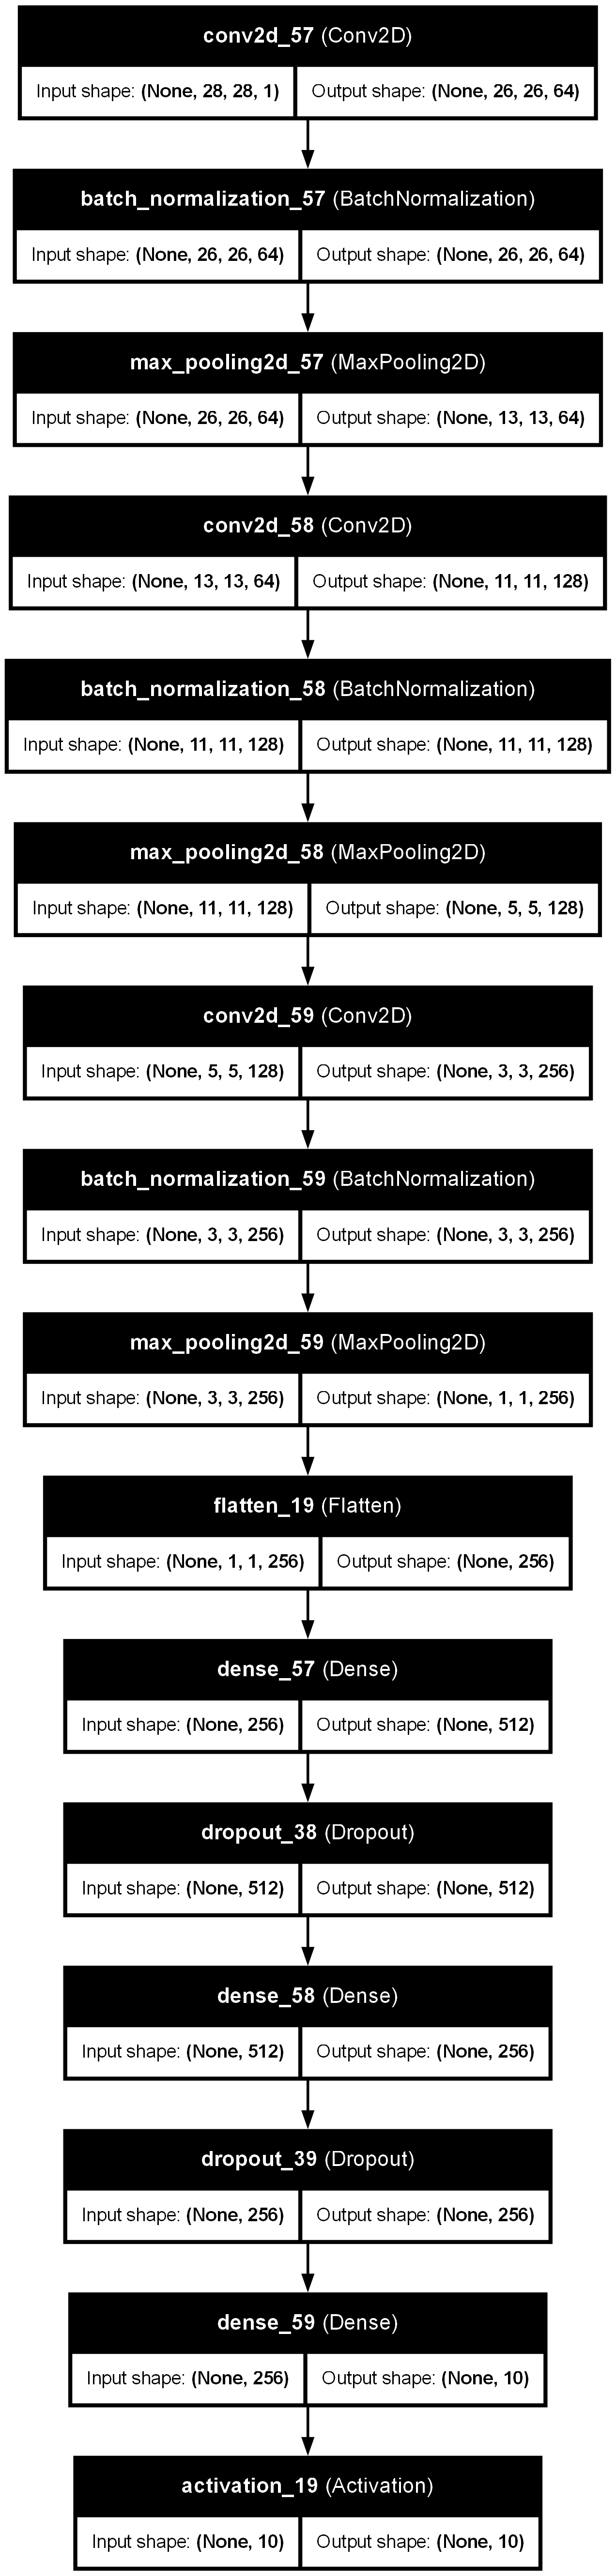

In [55]:
def build_model(input_size=(28,28,1), number_of_classes=10): #Function to build CNN model
    model = models.Sequential()
        
    #Add first convolutional layer. Uses 64 filters of kernel size 3x3 to extract low spatial features like corners and edges
    model.add(layers.Conv2D(64, kernel_size= (3,3), activation='relu', input_shape=input_size)) #64 filters of 3*3 size
    model.add(layers.BatchNormalization()) #Batch normalization to improve training speed and stability        model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Max pooling to reduce spatial dimensions
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #Add second convolutional layer. This time 128 filters of 3x3 kernel size
    model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu')) #128 filters of 3*3 size
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #Add third convolutional layer. Now 256 filters of 3x3 size
    model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu')) #256 filters
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    #Flatten the output for fully connected layers
    model.add(layers.Flatten()) #Flatten output to 1D
    model.add(layers.Dense(512, activation='relu')) #Fully connected layer with 512 neurons
    model.add(layers.Dropout(0.5)) #Dropout to prevent overfitting, randomly disable 50% of neurons during training to help generalise any unseen data
    model.add(layers.Dense(256, activation='relu')) #Another fully connected layer with 256 neurons
    model.add(layers.Dropout(0.5)) #Another dropout to prevent the overfitting

    #Output layer, using softmax activation for multi-class classification
    model.add(layers.Dense(number_of_classes)) #10 output classes
    model.add(layers.Activation('softmax')) #Softmax activation for multi-class classification
    
    optimizer_higher = Adam(learning_rate=0.01)  # Adam optimizer with a higher learning rate to compare learning rates
    optimizer_lower = Adam(learning_rate=0.0005)
    
    #Compile CNN model
    model.compile(
        optimizer='adam',  # Optimizer adjusts weights during training, chosen for its adaptive learning rate
        loss='sparse_categorical_crossentropy',  # Loss function for multi-class labels
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

model = build_model()
model.summary()  # Print model 
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)  # Save PNG diagram of the CNN


In [56]:
#model.compile(optimizer='SGD',
              #loss='categorical_crossentropy',
              #metrics=['accuracy'])


In [57]:
#model.compile(
    #optimizer='adam',  # Optimizer adjusts weights during training
    #loss='sparse_categorical_crossentropy',  # Loss function for multi-class labels
    #metrics=['accuracy']  # Track accuracy during training
#)

In [58]:
#ReLU used to have non-linearity and to avoid vanishing gradients
# Fits the model on the training data
model_history = model.fit(
    X_train, y_train, # Training data
    batch_size = BATCH_SIZE, # Batch size (128) gives a balance between gradient stability and speed of computation
    epochs = EPOCHS, #Epochs (5) to ensure high  and low loss
    validation_split = VALIDATION_SPLIT, # Validation data to monitor performance, reserves 20% of data to monitor generalisation
    verbose = 1 # Verbosity level (1 = progress bar
)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 183ms/step - accuracy: 0.8280 - loss: 0.5519 - val_accuracy: 0.1061 - val_loss: 13.8943
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 65s 172ms/step - accuracy: 0.9731 - loss: 0.0963 - val_accuracy: 0.9760 - val_loss: 0.0853
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.9801 - loss: 0.0665 - val_accuracy: 0.9774 - val_loss: 0.0813
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 87s 231ms/step - accuracy: 0.9855 - loss: 0.0508 - val_accuracy: 0.9801 - val_loss: 0.0669
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 230ms/step - accuracy: 0.9868 - loss: 0.0450 - val_accuracy: 0.9844 - val_loss: 0.0595


In [ ]:
#model_history = model.fit(X_train, y_train,
                          #batch_size=BATCH_SIZE,
                          #epochs=EPOCHS,
                          #verbose=1,
                          #validation_split=VALIDATION_SPLIT)


In [59]:
# Evaluate model on test data

test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
print('Test accuracy: ', test_acc) #Print test accuracy
print("Test loss: ", test_loss) #Print test loss

#Get prediction and print with classification report
y_prediction = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report: ")
print(classification_report(y_test, y_prediction, digits=3))

Test accuracy:  0.9847000241279602
Test loss:  0.06374668329954147
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Classification Report: 
              precision    recall  f1-score   support

           0      0.991     0.994     0.992       980
           1      0.992     0.993     0.993      1135
           2      0.991     0.969     0.980      1032
           3      0.970     0.990     0.980      1010
           4      0.987     0.992     0.989       982
           5      0.983     0.984     0.984       892
           6      0.996     0.989     0.992       958
           7      0.975     0.973     0.974      1028
           8      0.996     0.976     0.986       974
           9      0.968     0.987     0.977      1009

    accuracy                          0.985     10000
   macro avg      0.985     0.985     0.985     10000
weighted avg      0.985     0.985     0.985     10000



In [12]:
#High precison and high recall show a balanced performance for all 10 digits

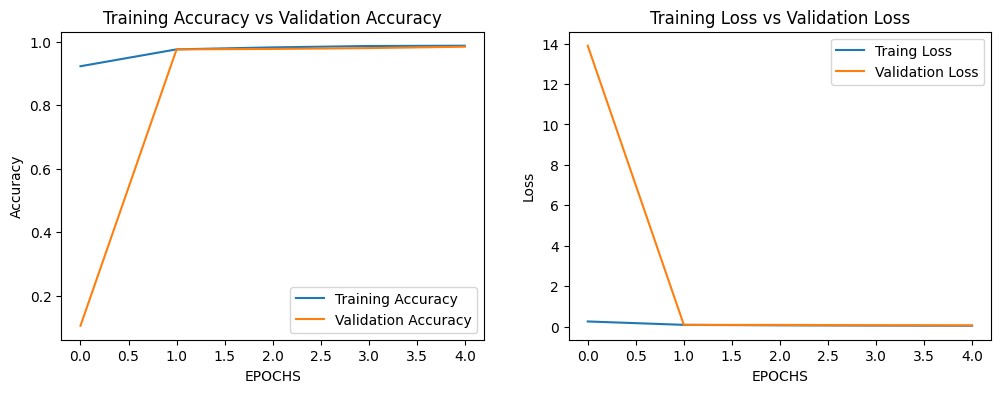

In [60]:
#Plot the training results

plt.figure(figsize=(12,4)) #Creates a figure with size 12x4

plt.subplot(1,2,1) #1 row, 2 columns, first subplot

plt.plot(model_history.history['accuracy'], label = 'Training Accuracy') #Plots Training Accuracy
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy') #Plots Validation Accuracy
plt.title("Training Accuracy vs Validation Accuracy") #Gives the subplot its title
plt.xlabel("EPOCHS") #Label for x-axis
plt.ylabel("Accuracy") #Label for y-axis
plt.legend() #Adds graphic to show which line is which

plt.subplot(1,2,2) #1 row, 2 columns, second subplot

plt.plot(model_history.history['loss'], label = 'Traing Loss') #Plots Training Loss
plt.plot(model_history.history['val_loss'], label = 'Validation Loss') #Plots Validation Loss
plt.title("Training Loss vs Validation Loss") #Gives the subplot its title
plt.xlabel("EPOCHS") #Label for x-axis
plt.ylabel("Loss") #Label for y-axis
plt.legend() #Adds graphic to show which line is which

plt.show() #Displays the figure with the two subplots

In [14]:
#Training and Validation accuracy level out just below 100%. Means we have good generalisation and minimal overfitting
#Training and Validation loss follow similar trend to accuracy curves

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


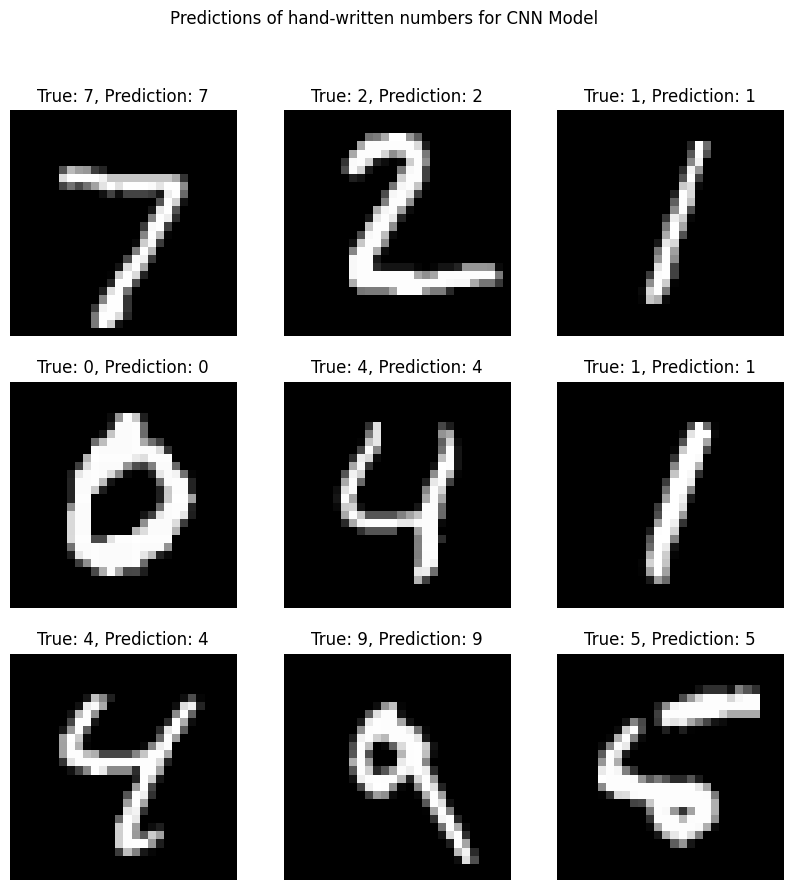

In [61]:
predictions = np.argmax(model.predict(X_test), axis=-1) #Get predicted class labels for test 

#Showing first 9 test images with true and predicted labels
plt.figure(figsize=(10,10)) #Creates a figure of size 10x10
for i in range(9): #Plot first 9 test images with predictions
    plt.subplot(3, 3, i+1) #3 rows, 3 columns
    plt.imshow(X_test[i].reshape(28,28), cmap='gist_grey') #Display image in grayscale
    plt.title(f"True: {y_test[i]}, Prediction: {predictions[i]}") #Title with true and predicted labels
    plt.axis('off') #Turn off axis
    
plt.suptitle("Predictions of hand-written numbers for CNN Model") #Overall title for the figure
plt.show() #Display the figure

In [24]:
#Simulation of k-fold cross-validation

k_fold = KFold(n_splits=3) #3-fold cross-validation
fold = 1 #starting number of folds

fold_accuracies = [] #List to store accuracies for each fold
fold_losses = []

for training_index, validation_index in k_fold.split(X_train): #Splits training data into mutliple different folds
    print(f"Training fold: {fold}")
    model = build_model() #builds new model
    model.fit(X_train[training_index], y_train[training_index], #ensures model is trained in the fold
              validation_data = (X_train[validation_index], y_train[validation_index]), #validated with remaining data
              epochs=3, #lowered for demonstration speed
              batch_size=128,
              verbose=1
              )
    validation_loss, validation_accuracy = model.evaluate(X_train[validation_index], y_train[validation_index], verbose=0) #Evaluates model on the validation split
    
    fold_accuracies.append(validation_accuracy)#Saves results into lists
    fold_losses.append(validation_loss)
    
    print(f"Fold {fold}, Validation Accuracy = {validation_accuracy}, Validation Loss = {validation_loss}")
    
    fold += 1 #goes to next fold and restarts process
    
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)

print("Final Results: ")
print(f"Average Validation Accuracy =  {average_accuracy}")
print(f"Average Validation Loss = {average_loss}")


Training fold: 1
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 214ms/step - accuracy: 0.8165 - loss: 0.5957 - val_accuracy: 0.1141 - val_loss: 13.2889
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.9691 - loss: 0.1072 - val_accuracy: 0.9620 - val_loss: 0.1406
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 196ms/step - accuracy: 0.9800 - loss: 0.0694 - val_accuracy: 0.9777 - val_loss: 0.0808
Fold 1, Validation Accuracy = 0.9776999950408936, Validation Loss = 0.08082425594329834
Training fold: 2
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 192ms/step - accuracy: 0.8229 - loss: 0.5796 - val_accuracy: 0.1141 - val_loss: 8.5171
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 249ms/step - accuracy: 0.9733 - loss: 0.0991 - val_accuracy: 0.9715 - val_loss: 0.1019
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.9812 - loss: 0.0646 - val_accuracy: 0.9721 - val_loss: 0.1067
Fold 2, Validation Accuracy = 0.9720500111579895, Validation Loss = 0.10666128993034363
Training 

In [ ]:
#We are varying the batch size to see how it impacts accuracy

batch_size64 = 64
batch_size256 = 256

model_smaller_batch_size = build_model()
model_history_smaller_batch_size = model_smaller_batch_size.fit(
    X_train, y_train,
    epochs = 5,
    batch_size = 128, #varying batch size
    validation_split = 0.2,
    verbose = 1
)

print("Validation accuracy with varying batch size: ", model_history_smaller_batch_size.history['val_accuracy'][-1])

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 355ms/step - accuracy: 0.7988 - loss: 0.6644 - val_accuracy: 0.1060 - val_loss: 10.4400
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.9734 - loss: 0.0943 - val_accuracy: 0.1238 - val_loss: 7.4326
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.9826 - loss: 0.0608 - val_accuracy: 0.9529 - val_loss: 0.1830
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 375ms/step - accuracy: 0.9865 - loss: 0.0481 - val_accuracy: 0.9813 - val_loss: 0.0721
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 79s 417ms/step - accuracy: 0.9877 - loss: 0.0411 - val_accuracy: 0.9837 - val_loss: 0.0575
Validation accuracy with varying batch size:  0.9837499856948853


In [18]:
#As expected, the validation accuracy slightly increases, but computation takes roughly twice as long

In [65]:
#We are varying the number of epochs to see how it impacts the accuracy and loss
epochs1 = 1
epochs2 = 2
epochs10 = 10

model_varying_epochs = build_model()
model_history_varying_epochs = model_varying_epochs.fit(
    X_train, y_train,
    epochs = 5, #Vary number of epochs
    batch_size = 128,
    validation_split = 0.2,
    verbose = 1
)

print("Validation accuracy with varying epochs: ", model_history_varying_epochs.history['val_accuracy'][-1])

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 242ms/step - accuracy: 0.8402 - loss: 0.5310 - val_accuracy: 0.1060 - val_loss: 13.5044
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.9724 - loss: 0.0936 - val_accuracy: 0.9735 - val_loss: 0.1018
Validation accuracy with varying epochs:  0.9735000133514404
